Crops Diseases Dectection Using Deep Learning

Capstone - CS Applied

Ashesi University

**Author** : Silas Sangmin

<h1>Necessary Imports</h1>

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt #data visualization
import torch
import torch.nn as nn  #cnn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset #data transformation
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from IPython.display import clear_output 
from torchsummary import summary              # for getting the summary of our model
from tqdm.notebook import tqdm #progress bar loader visualizer 
from __future__ import print_function, division
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
import time
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import os
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sn
cudnn.benchmark = True
plt.ion()   # interactive mode

<h3>Mount Google Drive</h3>

In [3]:
#Mount Google drive to load dataset on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Define Dataset Path and Get available Device (GPU if available)

In [4]:
ds_path ='/content/drive/MyDrive/plantVillageDataset/'

def get_device():
  """
  Get Available Device
  """
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  return device

device = get_device()
device

device(type='cuda', index=0)

<h3>Data Preprocessing and Augumentation Class</h3>

In [5]:
class Data_Preprocessing:
    """
    Data Preprocessing and Augmentation
    """
    def __init__(self,ds_path):
      self.dataset_path = ds_path # "/content/drive/MyDrive/plantVillageDataset/"
      self.unique_crops = []
      self.classes = os.listdir(self.dataset_path +'train')
      self.image_dataset= None
      self.dataloaders = None
      self.dataset_sizes = None
      self.batch_size = 32

    def get_unique_crops(self):
      #Get unique crops
      self.unique_crops = []
      for c in self.classes:
          class_name = c.split('_')
          if class_name[0] not in self.unique_crops:
              self.unique_crops.append(class_name[0])
      return self.unique_crops

    
    def transform_data(self):
      # Data augmentation and normalization for training
     
      data_transforms = {
          'train': transforms.Compose([
              transforms.RandomResizedCrop(224),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), # (x-mean/sd)
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ]),
          'valid': transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), # (x-mean/sd)
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ]),
          'test': transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), # (x-mean/sd)
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ]),
      }

      return data_transforms

    def get_datasets(self):
      data_transforms = self.transform_data()
      self.image_datasets = {x: datasets.ImageFolder(os.path.join(self.dataset_path, x),
                        data_transforms[x]) for x in ['train', 'valid','test']}

      self.dataset_sizes = {x: len(self.image_datasets[x]) for x in ['train', 'valid','test']}
      self.classes = self.image_datasets['train'].classes
      return self.image_datasets

    def get_data_loaders(self):
      image_datasets = self.get_datasets()
      self.dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=self.batch_size,
                     shuffle=True, num_workers=2) for x in ['train', 'valid','test']}
      return self.dataloaders

    





Create Instances of Data. Datasets, data_loaders, dataset_sizes have train,test and valid paths. Example: data_loaders['train'] gives train data loader

In [6]:

data_processing = Data_Preprocessing(ds_path)

unique_crops = data_processing.get_unique_crops()
data_sets= data_processing.get_datasets()
data_loaders = data_processing.get_data_loaders()
dataset_sizes = data_processing.dataset_sizes
class_names = data_processing.classes





In [7]:
#Dataset Summary
print("unique crops: ",unique_crops)
print("Train dataset size: ", dataset_sizes['train'])
print("Valid dataset size: ", dataset_sizes['valid'])
print("Test dataset size: ", dataset_sizes['test'])
print("Diseases/classes: ", class_names)

unique crops:  ['Corn', 'Pepper,', 'Potato', 'Orange', 'Tomato', 'Background', 'Cassava', 'Rice']
Train dataset size:  39596
Valid dataset size:  10557
Test dataset size:  2594
Diseases/classes:  ['Background_without_leaves', 'Cassava_Bacterial_Blight_(CBB)', 'Cassava_Brown_Streak_Disease_(CBSD)', 'Cassava_Green_Mottle_(CGM)', 'Cassava_Healthy', 'Cassava_Mosaic_Disease_(CMD)', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Rice_Brown_Spot', 'Rice_Healthy', 'Rice_Hispa', 'Rice_Leaf_Blast', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf

<h3>Data Visualization</h3>

In [8]:
class Visualization_class():
  """
  Ploting and visualizing Data
  """
  def __init__(self,dataloaders):
    self.dataloaders = dataloaders

  def show_image_batch(self):
    #Visualising a batch of images
    train_loader = self.dataloaders['valid']
    for images, labels in train_loader:
      fig, ax = plt.subplots(figsize=(20, 8))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
      break

  def show_images(self, inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

  def show_img_inv(self,data_sets):
    image, label  = data_sets['valid'][3200]
    print("disease:",data_sets['valid'].classes[label],"------> Label: ",label)
    fig,(ax1,ax2) = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
    ax1.imshow(image.permute(1,2,0))
    ax1.set_title("original image:")
    ax2.imshow(1-image.permute(1,2,0))
    ax2.set_title("inverted image")
    plt.show()

  def visualize_preds(self, model, num_images=6,dataloaders=data_loaders):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                self.show_images(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

  def plot_losses(self,record):
    train_losses = [train_loss.get('train_loss') for train_loss in record['train']]
    val_losses = [val_loss['valid_loss'] for val_loss in record['valid']]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.title('Loss vs Number of Epochs');
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(['Train Loss', 'Valid Loss'])

  def plot_accuracies(self,record):
    train_acc = [train_acc.get('train_acc').cpu() for train_acc in record['train']]
    val_acc = [val_acc.get('valid_acc').cpu() for val_acc in record['valid']]
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.title('Accuracies Vs Number of Epochs');
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(['Train Acc', 'Valid Acc'])
    

Create Instance/Object of Visualization class

In [9]:
Visualize = Visualization_class(dataloaders=data_loaders)



Visualize batch of images

disease: Orange___Haunglongbing_(Citrus_greening) ------> Label:  10


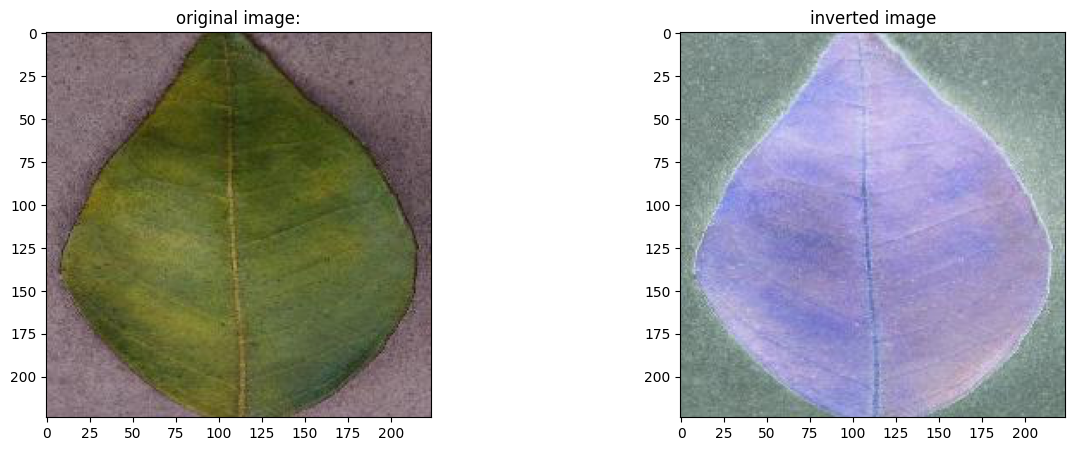

In [ ]:
#Show a sample image and iverted
Visualize.show_img_inv(data_sets=data_sets)

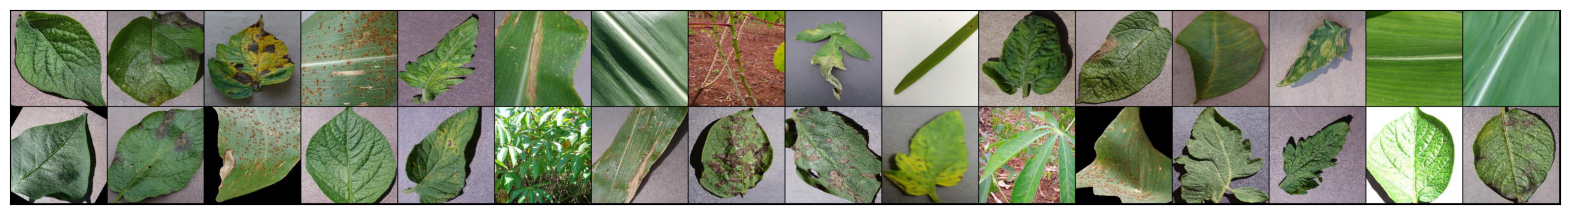

In [ ]:
# Show a batch of training data
Visualize.show_image_batch()

<h1>Model Building</h1>

In [10]:
class Base_model():
  """
  ResNet Model using transfer learning
  """
  def __init__(self,NUM_CLASSES):
    self.NUM_CLASSES = NUM_CLASSES #30
    RANDOM_SEED = 42
    torch.manual_seed(RANDOM_SEED)
    
    # self.model_ft = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
    self.resNet_model = torchvision.models.resnet18(pretrained=True)
    num_ftrs = self.resNet_model.fc.in_features
    self.resNet_model.fc = nn.Linear(num_ftrs, NUM_CLASSES) 
    self.resNet_model = self.resNet_model.to(device)
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer_ft = optim.SGD(self.resNet_model.parameters(), lr=0.001, momentum=0.9)
    # Change Learning rate by a factor of 0.1 after some epochs
    self.exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer_ft, step_size=8, gamma=0.1)

  

Model and optimizers

In [16]:
#Defining model and optimizers
restnet18 = Base_model(len(class_names))
model = restnet18.resNet_model
model = model.to(device)
criterion = restnet18.criterion
optimizer = restnet18.optimizer_ft
exp_lr_scheduler = restnet18.exp_lr_scheduler



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 224MB/s]


<h3>Model Training</h3>

In [ ]:
class Training_Model:
  """
  Model Training
  """
  def __init__(self):
    self.EPOCHS = 15
    self.RANDOM_SEED = 42
    self.VALIDATION_SPLIT = 0.2
    self.LEARNING_RATE = 0.001
    self.BATCH_SIZE = 16
    self.records = {'train':[],'valid':[]}

  def train_model(self, model, criterion, scheduler, optimizer, num_epochs=25,dataloaders=data_loaders):
    since = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            elif phase == 'valid':
                model.eval()   # Set model to evaluate mode

            total_loss = 0.0
            total_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                total_loss += loss.item() * inputs.size(0)
                total_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                # Change Learning rate by a factor of 0.1 every  epochs
                scheduler.step()

            epoch_loss = total_loss / dataset_sizes[phase]
            epoch_acc = total_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            self.records[phase].append({phase+'_loss': epoch_loss,phase+'_acc': epoch_acc })
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_accuracy:4f}')

    # load best model weights
    model.load_state_dict(best_model_weights)
    torch.save(model,'/content/drive/MyDrive/save_models/crop_labv2.pth')
    return model

  def predict_raw_image(self,model, single_img_path):
    """Predict disease"""
    #process image
    transforms1=transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img_ds = ImageFolder(single_img_path,transform= transforms1)
    img, label = img_ds[0]
    x = img.unsqueeze(0).to(device)
    output = model(x)
    _, preds  = torch.max(output, dim=1)
    return class_names[preds[0]]


  def predict_processed_image(self, model,crop_img):
    """Predict disease"""
    x = crop_img.unsqueeze(0).to(device)
    output = model(x)
    _, preds  = torch.max(output, dim=1)
    return class_names[preds[0]]

  

<h3>Train the model</h3>

In [ ]:
#Create an instance of training class
Train_model_class = Training_Model()


In [ ]:
#Train Model
restnet_model = Train_model_class.train_model(model,criterion,exp_lr_scheduler,optimizer,num_epochs= 15,dataloaders=data_loaders)
train_records =  Train_model_class.records

Epoch 1/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.6306 Acc: 0.8159


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.2464 Acc: 0.9143

Epoch 2/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.2764 Acc: 0.9053


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1789 Acc: 0.9381

Epoch 3/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.2179 Acc: 0.9249


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1486 Acc: 0.9453

Epoch 4/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.1882 Acc: 0.9356


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1374 Acc: 0.9515

Epoch 5/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.1768 Acc: 0.9391


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1288 Acc: 0.9528

Epoch 6/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.1625 Acc: 0.9436


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1240 Acc: 0.9555

Epoch 7/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.1515 Acc: 0.9464


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1189 Acc: 0.9577

Epoch 8/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.1449 Acc: 0.9486


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1178 Acc: 0.9584

Epoch 9/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.1242 Acc: 0.9569


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1082 Acc: 0.9627

Epoch 10/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.1221 Acc: 0.9583


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1115 Acc: 0.9619

Epoch 11/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.1184 Acc: 0.9588


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1055 Acc: 0.9625

Epoch 12/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.1187 Acc: 0.9585


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1037 Acc: 0.9637

Epoch 13/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.1143 Acc: 0.9599


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1074 Acc: 0.9626

Epoch 14/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.1131 Acc: 0.9614


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1096 Acc: 0.9613

Epoch 15/15
--------------------------------------------------


  0%|          | 0/1238 [00:00<?, ?it/s]

train Loss: 0.1122 Acc: 0.9615


  0%|          | 0/330 [00:00<?, ?it/s]

valid Loss: 0.1082 Acc: 0.9622

Training complete in 201m 14s
Best val Acc: 0.963721


<h3>Visualization and Model Evaluation</h3>

In [11]:
def evaluate_model(model, dataloader, criterion):
  """
  Evaluate Model on test data
  """
  model.eval() # Set model to evaluate mode
  total_loss = 0.0
  total_corrects = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in tqdm(dataloader['test']):
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          total_loss += loss.item() * inputs.size(0)
          total_corrects += torch.sum(preds == labels.data)

          all_preds.extend(preds.cpu().numpy()) # Append predictions to all_preds list
          all_labels.extend(labels.data.cpu().numpy()) # Append ground truth labels to all_labels list

  epoch_loss = total_loss / dataset_sizes['test']
  epoch_acc = total_corrects.double() / dataset_sizes['test']

  print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
  #records['test'].append({'test_loss': epoch_loss, 'test_acc': epoch_acc})
  # Calculate precision and recall
  precision = precision_score(all_labels, all_preds, average='weighted')
  recall = recall_score(all_labels, all_preds, average='weighted')
  f1 = f1_score(all_labels, all_preds, average='weighted')

  print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score: {f1:.4f}')

  eval_dict = {'all_preds': all_preds, 'all_labels': all_labels, 'precision': precision,'recall': recall,'f1': f1}
  return eval_dict

In [12]:
def plot_confusion_matrix(all_preds, all_labels):
  """
  Plotting Confusing Matrix
  """
  cm = confusion_matrix(all_labels, all_preds)
  classes = list(class_names)

  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')

  for i in range(len(classes)):
      for j in range(len(classes)):
          plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

  plt.show() 

In [17]:
#Run Evaluation version 2
eval_dict = evaluate_model(model, data_loaders, criterion) 

  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 0.1853 Acc: 0.9356
Precision: 0.9436, Recall: 0.9356, F-Score: 0.9333


In [ ]:
#Run Evaluation Version 1
eval_dict = evaluate_model(model, data_loaders, criterion) 

  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 0.2204 Acc: 0.9217
Precision: 0.9180, Recall: 0.9217, F-Score: 0.9166


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
#Evaluation Summary
all_preds, all_labels= eval_dict['all_preds'],eval_dict['all_labels']
precision, recall,fScore = eval_dict['precision'],eval_dict['recall'],eval_dict['f1']

print(f'Precision: {precision:.4f}\n Recall: {recall:.4f}\n F-Score: {fScore:.4f}')

Precision: 0.9436
 Recall: 0.9356
 F-Score: 0.9333


In [ ]:
#Evaluation Summary
all_preds, all_labels= eval_dict['all_preds'],eval_dict['all_labels']
precision, recall,fScore = eval_dict['precision'],eval_dict['recall'],eval_dict['f1']

print(f'Precision: {precision:.4f}\n Recall: {recall:.4f}\n F-Score: {fScore:.4f}')


Precision: 0.9180
 Recall: 0.9217
 F-Score: 0.9166


# Plots

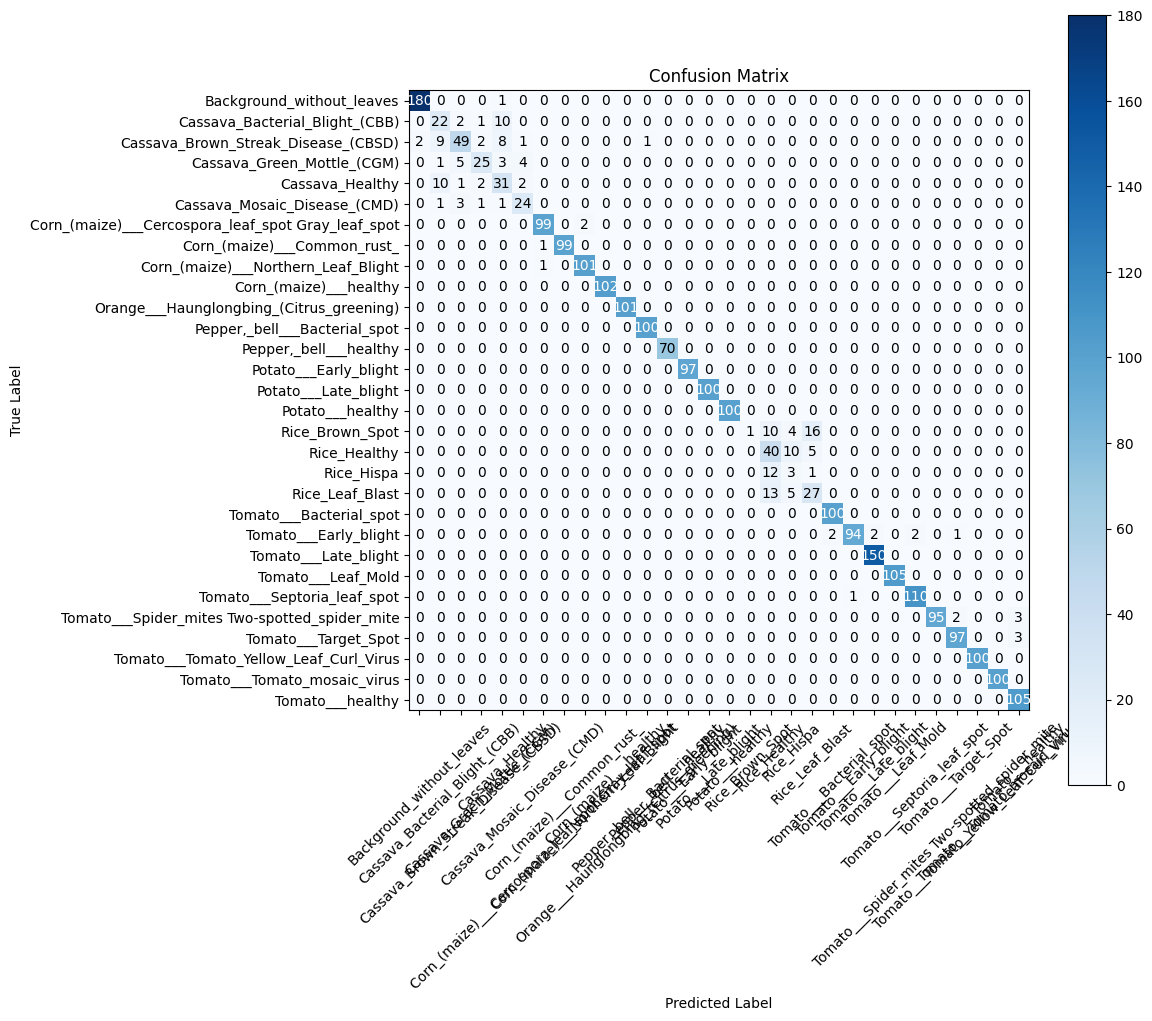

In [19]:
#Version 2
plot_confusion_matrix(all_preds, all_labels)

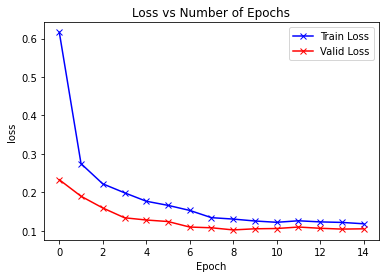

In [ ]:

Visualize.plot_losses(train_records)

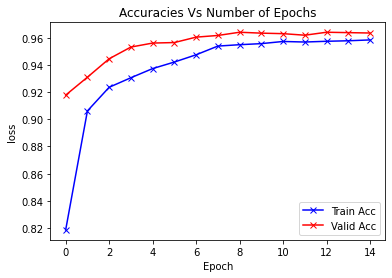

In [ ]:
Visualize.plot_accuracies(train_records)

<h3>Testing Sample Images</h3>

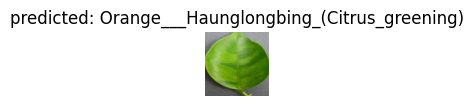

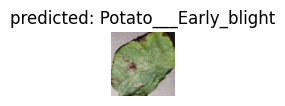

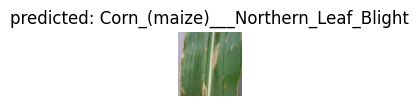

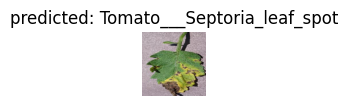

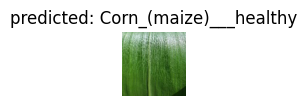

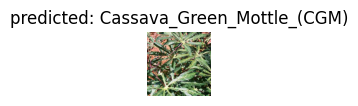

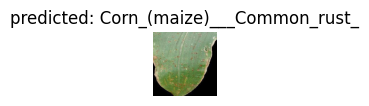

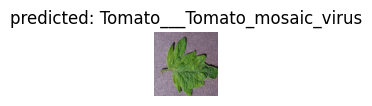

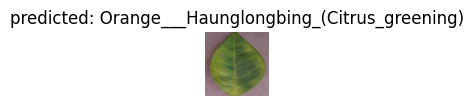

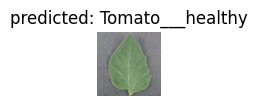

In [21]:

Visualize.visualize_preds(model,10,dataloaders=data_loaders)

Single Test Image prediction

In [ ]:
single_img_path='/content/drive/MyDrive/test_img'



In [ ]:
Train_model_class.predict_raw_image(model,single_img_path)

'Tomato___Late_blight'

In [ ]:
Train_model_class.predict_raw_image(model,single_img_path)

'Background_without_leaves'

Label: some_class , Predicted: Tomato___Septoria_leaf_spot


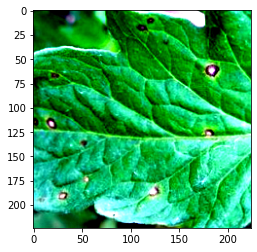

In [ ]:
single_img_path='/content/drive/MyDrive/test_img'
#process image
transforms1=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img_ds = ImageFolder(single_img_path,transform= transforms1)
img, label = img_ds[11] 

plt.imshow(img.permute(1, 2, 0))
print('Label:', img_ds.classes[label], ', Predicted:', Train_model_class.predict_processed_image(model,img))

Loading Saved Model

In [ ]:
loaded_model = torch.load('/content/drive/MyDrive/save_models/crop_labv2.pth')
loaded_model.to(device)



Label: some_class , Predicted: Tomato___Septoria_leaf_spot


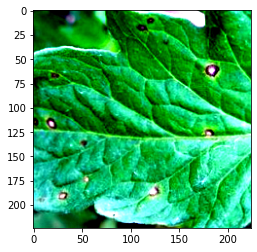

In [ ]:
plt.imshow(img.permute(1, 2, 0))
print('Label:', img_ds.classes[label], ', Predicted:', Train_model_class.predict_processed_image(loaded_model,img))